# 노드 10. 가중치 초기화와 배치 정규화

## 10.1 가중치 초기화 (Weights Initialization)

>가중치 초기화는 신경망의 성능에 큰 영향을 주는 요소 중 하나다. 만약 가중치의 값이 일부 값으로 치우치게 되면 활성화 함수를 통과한 값들도 치우치게 되고, 결국 표현할 수 있는 신경망의 수가 적어지는 문제가 발생한다. 보통 가중치 초기값으로 0에 가까운 무작위 값을 사용하더라도 초기값에 따라서 모델의 성능 차이가 발생할 수 있다. 즉, 모델의 활성화 값이 골고루 분포 되는 것이 중요하다.

>가중치 초기화 방법에 따라서 어떻게 달라지는지 살펴보기 위해 지정된 활성화 함수 activation과 초기화 initializer에 따라 모델을 생성하는 build_model 함수를 정의한다.






다층 퍼셉트론(Multilayer Perceptron, MLP) 구조의 모델 생성 함수

In [ ]:
from tensorflow.keras import models, layers, optimizers

# MLP 모델을 구성하는 함수 정의
def build_model(activation, initializer):
    model = models.Sequential()

    # 입력층 (400개의 타임스텝, 각 스텝마다 20개의 피처가 있는 시계열 형태)
    model.add(layers.Input(shape=(400, 20), name='input'))

    # 은닉층 5개: 각 층은 20개 유닛, 전달받은 활성화 함수와 가중치 초기화 방식 사용
    model.add(layers.Dense(20, activation=activation, name='hidden1',
                           kernel_initializer=initializer))
    model.add(layers.Dense(20, activation=activation, name='hidden2',
                           kernel_initializer=initializer))
    model.add(layers.Dense(20, activation=activation, name='hidden3',
                           kernel_initializer=initializer))
    model.add(layers.Dense(20, activation=activation, name='hidden4',
                           kernel_initializer=initializer))
    model.add(layers.Dense(20, activation=activation, name='hidden5',
                           kernel_initializer=initializer))

    # 출력층이 없음: 이는 아마도 중간 feature extractor 역할이거나,
    # 마지막에 추가하는 방식으로 구성할 수 있음

    # 모델 컴파일: 다중 클래스 분류용 sparse_categorical_crossentropy 사용
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.SGD(),
                  metrics=['accuracy'])

    return model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import initializers, activations

sns.set_style('white')

# 은닉층의 출력값 분포 시각화 함수
def show_layer(model):
  # 무작위 입력 데이터 생성 (샘플 수 400개, 피처 20개)
  input = np.random.randn(400, 20)

  plt.figure(figsize=(12, 6))
  for i in range(1, 6):
    name = 'hidden' + str(i)
    layer = model.get_layer(name)  # 해당 이름의 층 가져오기

    # 해당 층을 통과한 출력값 계산 (텐서플로우 텐서)
    input = layer(input)

    plt.subplot(1, 6, i)
    plt.title(name)

    # 텐서플로우 텐서를 넘파이 배열로 변환 후 flatten → 히스토그램 그리기
    # flatten(): 다차원 배열을 1차원으로 펼침
    plt.hist(input.numpy().flatten(), bins=20, range=(-1, 1))

    plt.subplots_adjust(wspace=0.5, hspace=0.5)

  plt.show()

<br>

딥러닝 모델의 은닉층 출력값 분포를 시각적으로 확인
- 활성화 함수(activation)와 가중치 초기화 방식(initializer)에 따라, 신경망 은닉층의 출력값(activation)이 어떻게 분포되는지 시각화
- 어떤 초기화 방식이 더 나은 활성 분포를 유도하는지, 초깃값과 활성화 함수의 궁합을 분석하기 위한 실험
- 특히 sigmoid 함수처럼 출력 범위가 제한적인 경우, 층이 깊어지면서 정보가 손실되는 현상(ex. gradient vanishing)을 시각적으로 관찰할 수 있음
    - 점점 출력값이 한쪽(거의 0 또는 거의 1)에 몰리는 현상이 관찰될 수 있음
    - 신경망이 깊어질수록 표현력이 제한되며, 정보가 소실되기 쉽기 때문

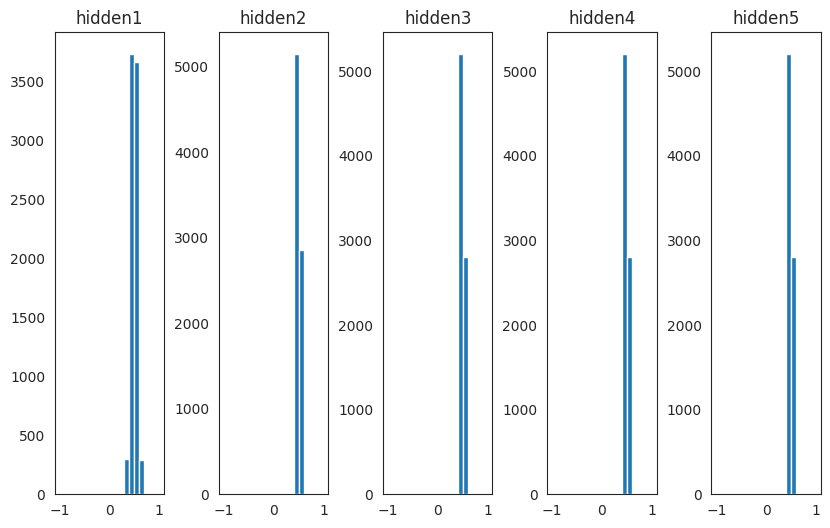

In [ ]:
# 활성화 함수: sigmoid, 초기화 방식: RandomNormal
# : 평균 0, 표준편차 0.05의 정규분포에서 초기 가중치를 무작위로 초기화
model = build_model(activations.sigmoid, initializers.RandomNormal())
show_layer(model)

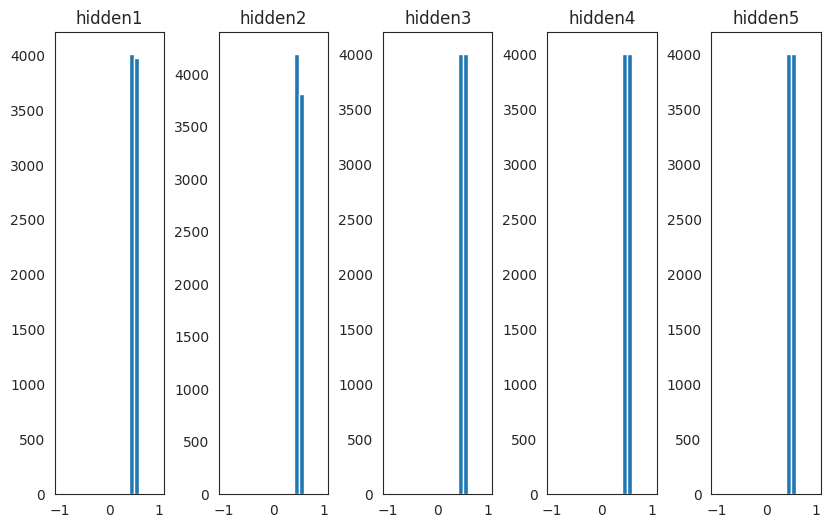

In [ ]:
# 활성화 함수: sigmoid, 초기화 방식: RandomUniform
# : 가중치가 균등 분포로 초기화
model = build_model(activations.sigmoid, initializers.RandomUniform())
show_layer(model)

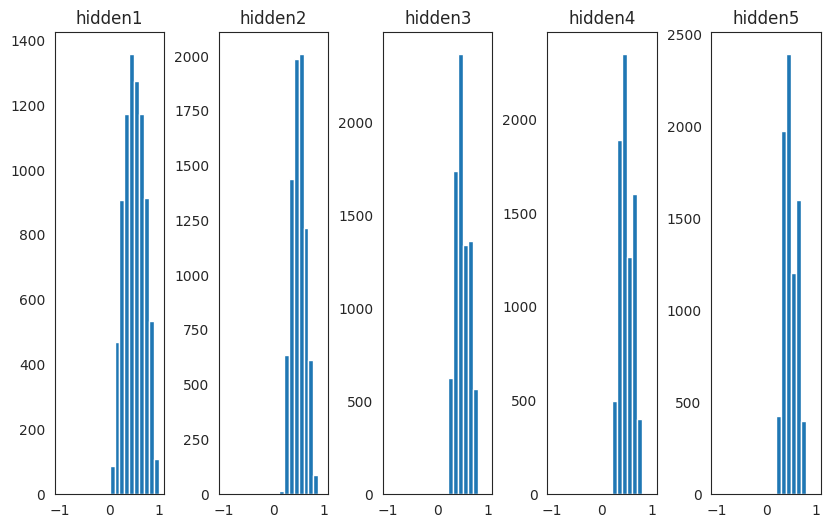

In [ ]:
# 활성화 함수: sigmoid, 초기화 방식: GlorotNormal
# = Xavier 초기화
# : 층의 입력/출력 개수를 고려해 표준 정규분포 기반으로 가중치 설정
model = build_model(activations.sigmoid, initializers.GlorotNormal())
show_layer(model)

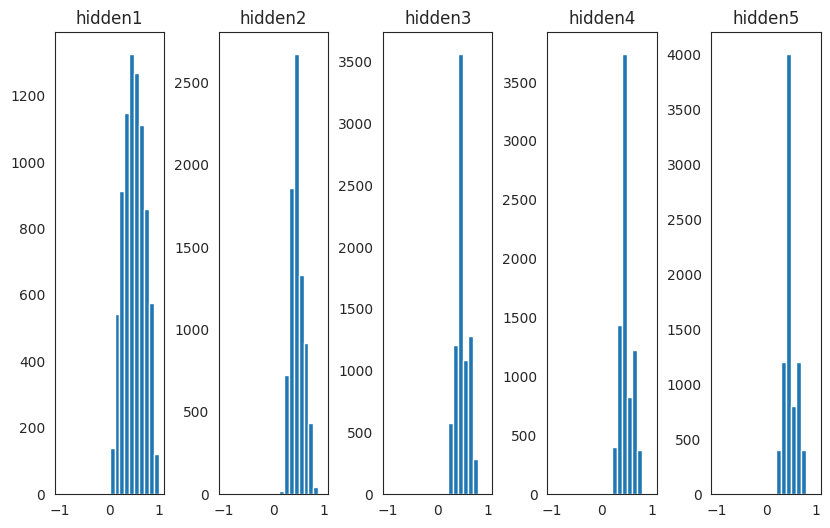

In [ ]:
# 활성화 함수: sigmoid, 초기화 방식: GlorotUniform
# : 입력과 출력 노드 개수를 고려하여 [-limit, limit] 구간에서 균등 분포로 가중치 초기화
# : 입력과 출력 간의 균형 유지를 잘 도와주기 때문에
#   -> RandomUniform 보다는 포화 현상이 완화되고, gradient vanishing 위험도 비교적 적음
model = build_model(activations.sigmoid, initializers.GlorotUniform())
show_layer(model)

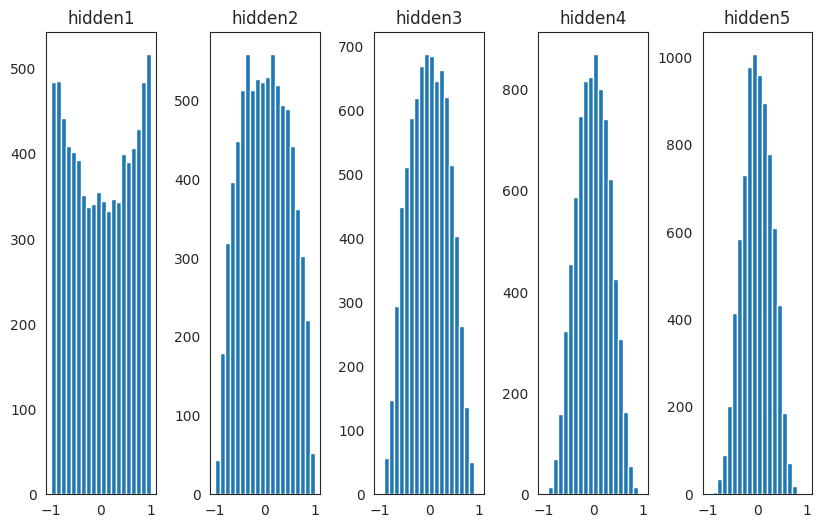

In [ ]:
# 활성화 함수: tanh, 초기화 방식: GlorotUniform
# tanh: 출력 범위 [-1, 1], 중심 0 -> gradient 흐름이 더 원활함
# = Xavier 초기화
# : 입력/출력 유닛 수 기반으로 균등 분포 설정
model = build_model(activations.tanh, initializers.GlorotUniform())
show_layer(model)

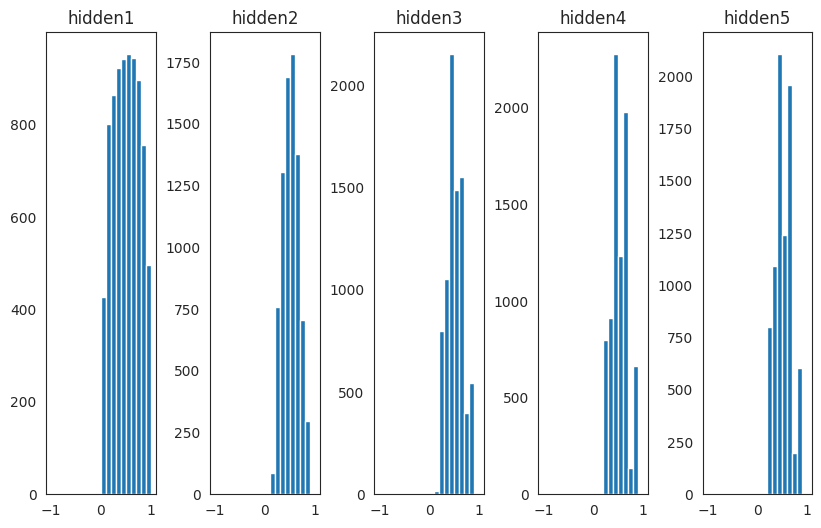

In [ ]:
# 활성화 함수: sigmoid, 초기화 방식: HeNormal
# : ReLU 계열에 최적화된 초기화 기법 → Sigmoid와는 상성이 좋지 않음
model = build_model(activations.sigmoid, initializers.HeNormal())
show_layer(model)

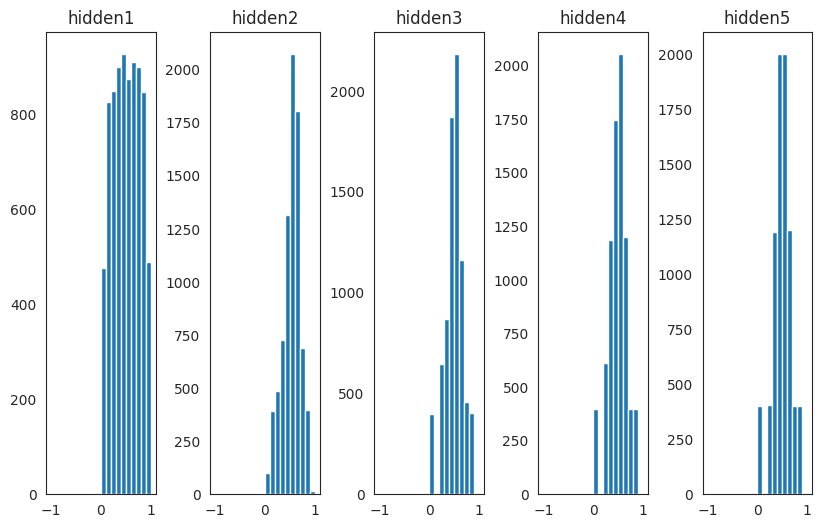

In [ ]:
# 활성화 함수: sigmoid, 초기화 방식: HeUniform
# : ReLU 기반에 최적화된 초기화 방식 (분산이 큼)
model = build_model(activations.sigmoid, initializers.HeUniform())
show_layer(model)

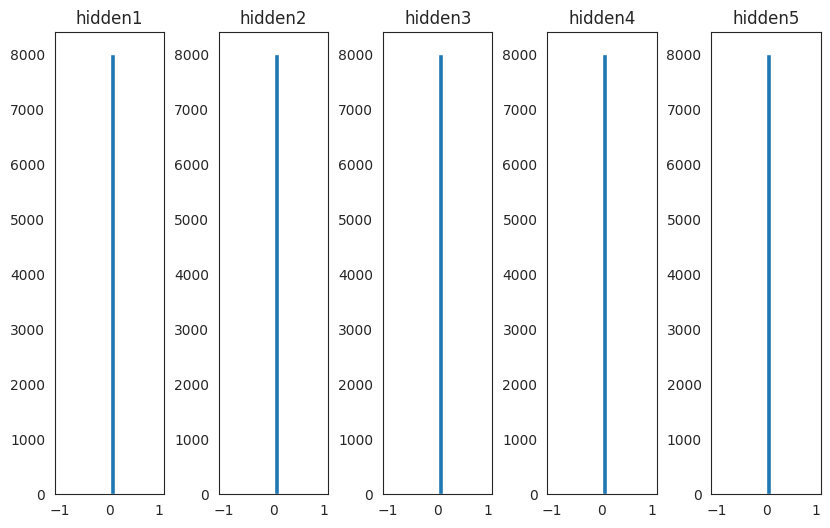

In [ ]:
# 활성화 함수: relu, 초기화 방식: Zeros
# : 모든 weight를 0으로 초기화 -> 모든 뉴런이 같은 출력을 생성하는 문제
model = build_model(activations.relu, initializers.Zeros())
show_layer(model)

위 조합의 문제점

| 항목            | 내용                                             |
| ------------- | ---------------------------------------------- |
| `Zeros` 초기화 | 모든 weight가 0이기 때문에 모든 뉴런이 같은 출력을 생성함       |
| ReLU의 결과   | 입력값이 0이므로, 첫 forward에서 모든 뉴런은 0을 출력        |
| 학습 정체       | 역전파 시, gradient가 모두 동일해서 가중치가 계속 0인 상태로 남음     |
| 결론    | 모든 층에서 뉴런이 동일하게 반응 → 표현력 전무, 학습 불* |

<br>

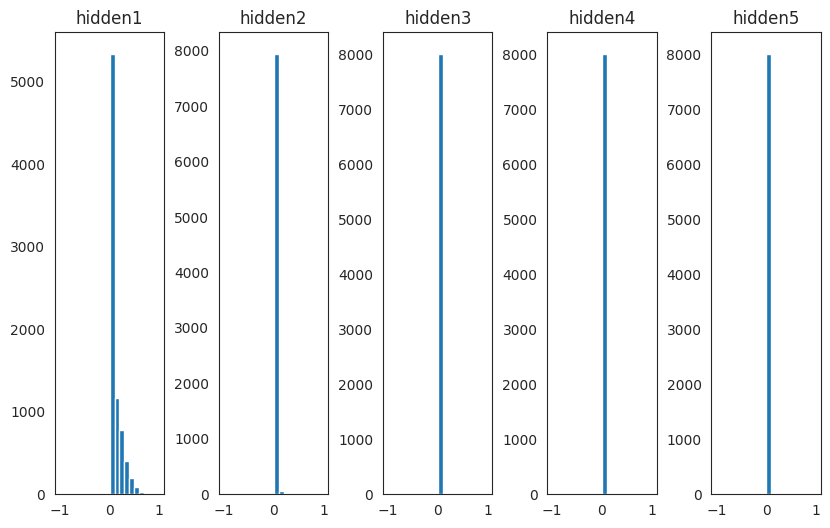

In [ ]:
# 활성화 함수: relu, 초기화 방식: RandomNormal
# : 평균 0, 표준편차 0.05의 정규분포
model = build_model(activations.relu, initializers.RandomNormal())
show_layer(model)

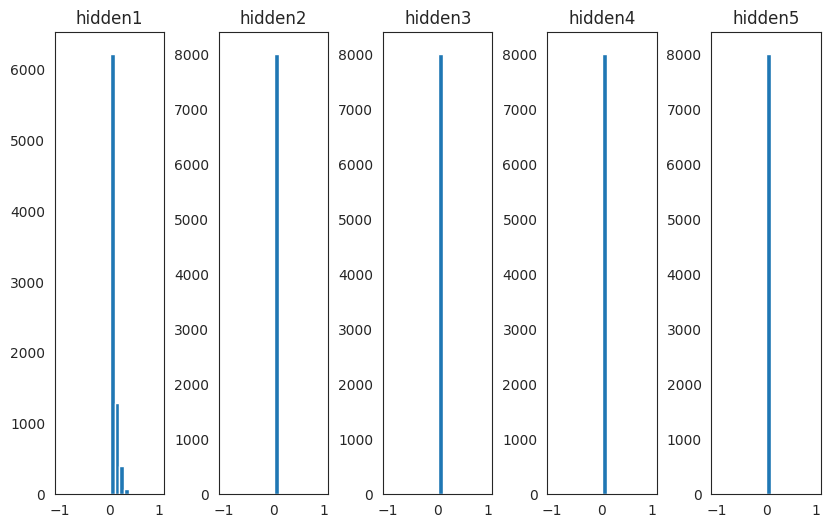

In [ ]:
# 활성화 함수: relu, 초기화 방식: RandomUniform
# : 기본 범위는 [-0.05, 0.05]
model = build_model(activations.relu, initializers.RandomUniform())
show_layer(model)

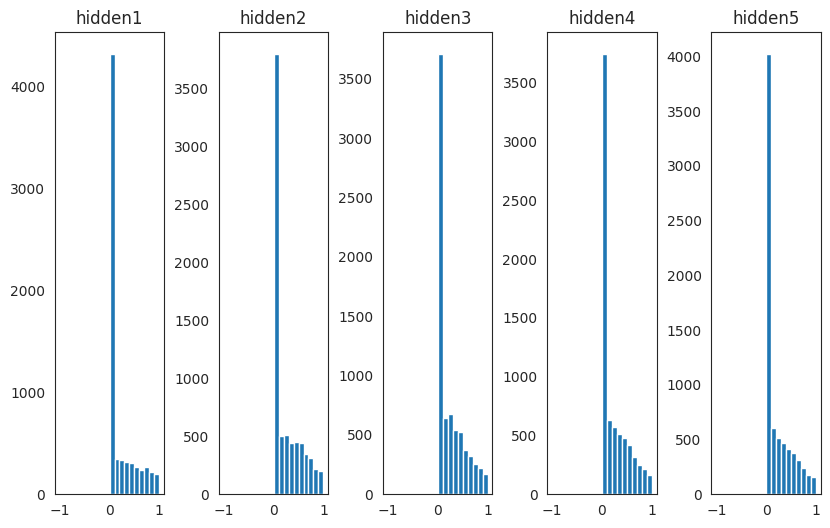

In [ ]:
# 활성화 함수: relu, 초기화 방식: RandomUniform
model = build_model(activations.relu, initializers.GlorotNormal())
show_layer(model)

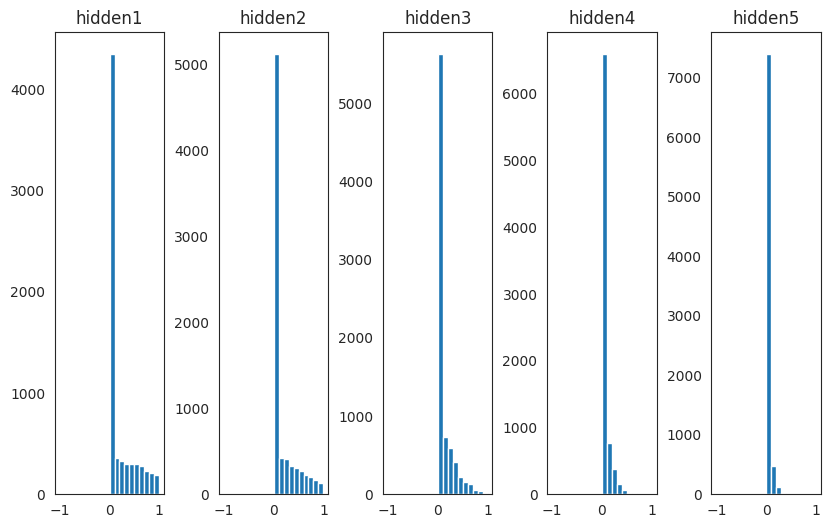

In [ ]:
# 활성화 함수: relu, 초기화 방식: GlorotUniform
model = build_model(activations.relu, initializers.GlorotUniform())
show_layer(model)

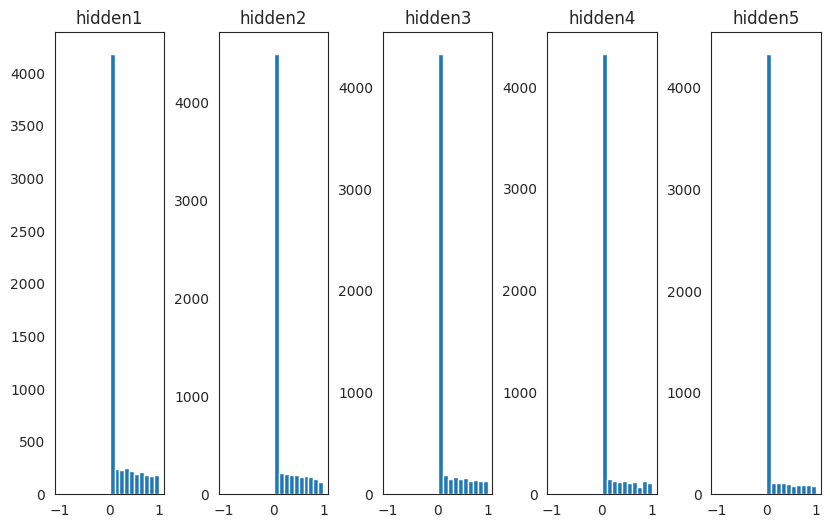

In [ ]:
# 활성화 함수: relu, 초기화 방식: HeNormal
model = build_model(activations.relu, initializers.HeNormal())
show_layer(model)

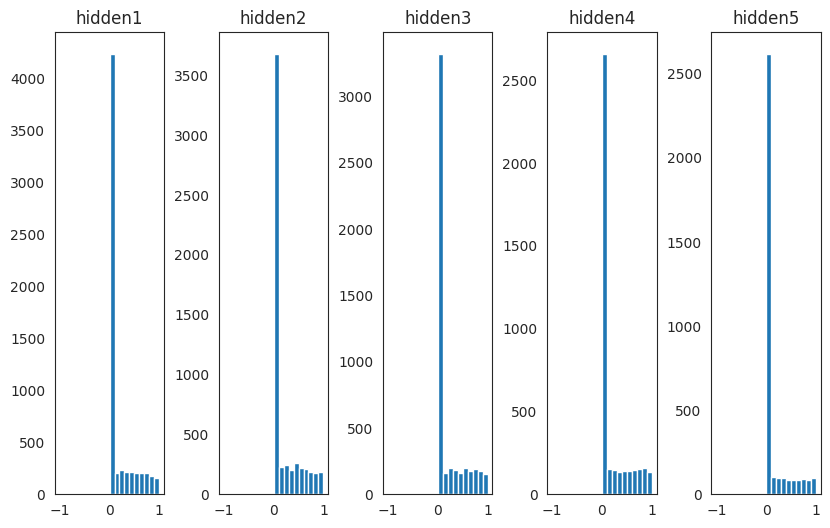

In [ ]:
# 활성화 함수: relu, 초기화 방식: HeUniform
model = build_model(activations.relu, initializers.HeUniform())
show_layer(model)

<br>
<br>

## 10.2 Reuters 딥러닝 모델 예제

Keras 내장 Reuters 뉴스 분류 데이터셋
- 경제 관련 뉴스 기사 11,000여 개를 46개 주제(Class)로 분류한 다중 클래스 텍스트 분류 데이터셋

In [ ]:
from keras.datasets import reuters
import numpy as np

# Reuters 뉴스 기사 데이터셋 로드
# 단어 빈도 기준 상위 10,000개만 사용 → 과적합 방지, 계산량 감소
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print(len(train_data))  # 각 기사마다 단어 인덱스로 이루어진 리스트 (List[int])
print(len(test_data))   # 해당 기사의 주제를 나타내는 정수값 (int, 0~45)
print(len(set(train_labels)))

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
8982
2246
46


In [ ]:
# Reuters 데이터셋에서 사용된 단어와 정수 인덱스의 매핑 정보 가져오기
# : Keras에서는 텍스트 데이터를 모델에 넣기 위해 단어를 정수로 인코딩함
# → 각 단어가 어떤 숫자로 인코딩되었는지 알려주는 딕셔너리 반환
word_index = reuters.get_word_index()

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
# 정수 인덱스를 단어로 매핑하는 딕셔너 생성
# : word_index는 {'the': 1, 'of': 2, ...} 형태로 단어를 정수 인덱스로 매핑한 딕셔너리인데
# : key와 value를 뒤집어 {1: 'the', 2: 'of', ...} 형태의 index_word 생성
# -> 뉴스 본문은 정수 인덱스 리스트로 구성되어 있으므로 이를 사람이 읽을 수 있는 단어로 변환하려면 역 매핑이 필요
# -> key와 value를 뒤집은 새로운 사전 index_word를 생성하여 숫자 인덱스로부터 단어를 찾을 수 있도록
index_word = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
# 정수 인덱스들로 이루어진 첫 번째 뉴스 기사(정수 인덱스 리스트)를
# 공백 기준 문자열로 연결
news = ' '.join([str(i) for i in train_data[0]])
news

'1 2 2 8 43 10 447 5 25 207 270 5 3095 111 16 369 186 90 67 7 89 5 19 102 6 19 124 15 90 67 84 22 482 26 7 48 4 49 8 864 39 209 154 6 151 6 83 11 15 22 155 11 15 7 48 9 4579 1005 504 6 258 6 272 11 15 22 134 44 11 15 16 8 197 1245 90 67 52 29 209 30 32 132 6 109 15 17 12'

In [ ]:
# index_word: 정수 인덱스를 실제 단어로 바꿔주는 딕셔너리
# train_data[0]: 첫 번째 뉴스 기사 (단어 인덱스 리스트)
#  - i-3: 0~2는 특수 토큰(<PAD>, <START>, <UNK>)이므로 실제 단어 인덱스는 3부터 시작
#  - get(i-3, '?'): 해당 인덱스가 존재하지 않으면 '?'로 대체
# 결과적으로 뉴스 기사 전체를 단어 기준으로 연결한 문자열을 생성
news = ' '.join([index_word.get(i-3, '?') for i in train_data[0]])
news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

<br>

정수 인덱스로 이루어진 뉴스 기사 데이터를 원-핫 인코딩 벡터로 변환하는 함수

In [ ]:
def one_hot_encoding(data, dim=10000):
  # 각 샘플마다 dim 크기의 0으로 채워진 배열 생성
  results = np.zeros((len(data), dim))

  # 각 뉴스 기사(정수 리스트)에 대해 해당 위치에 1을 세팅
  for i, d in enumerate(data):
    results[i, d] = 1.  # 해당 기사에 등장한 단어 인덱스를 1로 표시

  return results

# 훈련 및 테스트 데이터를 원-핫 인코딩 수행
x_train = one_hot_encoding(train_data)
x_test = one_hot_encoding(test_data)

# 첫 번째 뉴스 기사의 원-핫 인코딩 벡터 출력
print(x_train[0])

[0. 1. 1. ... 0. 0. 0.]


In [ ]:
# 뉴스 분류 문제의 다중 클래스 레이블 확인
print(train_labels[5])
print(train_labels[15])
print(train_labels[25])
print(train_labels[35])
print(train_labels[45])

4
8
1
4
20


<br>

다중 분류 문제를 위한 레이블 전처리
- train_labels와 test_labels의 정수형 클래스 라벨을 원-핫 인코딩

In [ ]:
from tensorflow.keras import utils

# train_labels와 test_labels는 정수형 레이블 (예: 0, 1, 2, ..., 45)
# 이를 신경망에서 사용할 수 있도록 원-핫 벡터로 변환
y_train = utils.to_categorical(train_labels)
y_test = utils.to_categorical(test_labels)

# 정수 레이블과 원-핫 벡터 결과 비교 출력
print(train_labels[5], y_train[5])
print(train_labels[15], y_train[15])
print(train_labels[25], y_train[25])

4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<br>

신경망 모델(MLP) 정의
- Reuter 뉴스 데이터셋처럼 입력 차원이 큰 다중 분류 문제 해결

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

model = models.Sequential()

# 입력층 + 첫 번째 은닉층 (입력 차원: 10000, 유닛: 128, 활성화: ReLU)
model.add(layers.Dense(128, activation='relu', input_shape=(10000, ), name='input'))
# 두 번째 은닉층 (유닛: 128, 활성화: ReLU)
model.add(layers.Dense(128, activation='relu', name='hidden'))
# 출력층 (클래스 수: 46개 → softmax로 확률 예측)
model.add(layers.Dense(46, activation='softmax', name='output'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<br>

모델 컴파일

In [ ]:
# 모델 컴파일: 손실 함수, 최적화 알고리즘, 평가 지표 설정
model.compile(optimizer='rmsprop',              # 최적화 알고리즘 (Adam도 가능)
              loss='categorical_crossentropy',  # 다중 클래스 분류용 손실 함수
              metrics=['accuracy'])             # 정확도를 성능 지표로 사용

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,302,574 (4.97 MB)

 Trainable params: 1,302,574 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

<br>

모델 학습

In [ ]:
history = model.fit(
    x_train, y_train,             # 훈련 데이터 및 레이블
    epochs=40,                    # 전체 데이터셋을 40회 반복 학습
    batch_size=512,               # 한 번에 512개씩 처리하여 weight 업데이트
    validation_data=(x_test, y_test)  # 매 에폭 후 검증 데이터로 평가
)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.4157 - loss: 2.7960 - val_accuracy: 0.6202 - val_loss: 1.5604
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7120 - loss: 1.2882 - val_accuracy: 0.7173 - val_loss: 1.2233
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7969 - loss: 0.9539 - val_accuracy: 0.7520 - val_loss: 1.0906
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8421 - loss: 0.7290 - val_accuracy: 0.7765 - val_loss: 0.9828
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8808 - loss: 0.5569 - val_accuracy: 0.7832 - val_loss: 0.9656
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9063 - loss: 0.4436 - val_accuracy: 0.7943 - val_loss: 0.9127
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9235 - loss: 0.3523 - val_accuracy: 0.7907 - val_loss: 0.9314
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9339 - loss: 0.2922 - val_accuracy: 0.8063 - 

<br>

모델 학습 손실과 정확도 추이 시각화

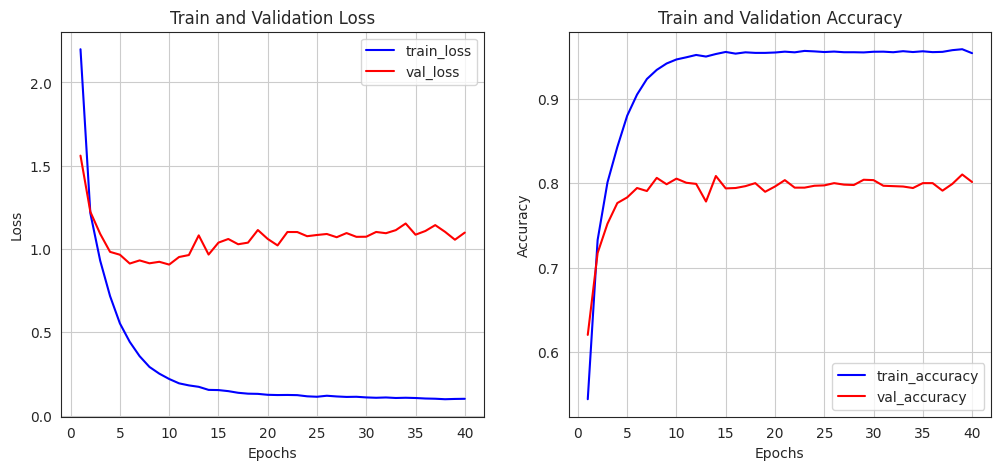

In [ ]:
import matplotlib.pyplot as plt

# 학습 기록(history 객체에서 손실과 정확도 정보 추출)
history_dict = history.history

# 훈련 및 검증 손실
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# 에폭 수 생성 (1부터 시작)
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

#  1. 손실(Loss) 시각화
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

# 2. 정확도(Accuracy) 시각화
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

<br>

build_model() 함수 정의
- 신경망 모델을 생성
- 주어진 커널 초기화 방법(initializer)을 사용해 각 레이어를 초기화
- 모델 학습
- 학습 결과(history) 반환



In [ ]:
def build_model(initializer):
  # 모델 정의 (Sequential 방식)
  model = models.Sequential()

  # 입력층 + 첫 번째 은닉층
  model.add(layers.Dense(128,
                         activation='relu',
                         kernel_initializer=initializer,  # 초기화 방법 주입
                         input_shape=(10000, ),
                         name='input'))

  # 두 번째 은닉층
  model.add(layers.Dense(128,
                         activation='relu',
                         kernel_initializer=initializer,
                         name='hidden'))

  # 출력층 (46개의 클래스 → 소프트맥스 다중 분류)
  model.add(layers.Dense(46,
                         activation='softmax',
                         name='output'))

  # 모델 컴파일 (손실 함수: categorical_crossentropy, 최적화: RMSprop)
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  # 모델 학습 (학습 기록을 history 객체로 반환)
  history = model.fit(x_train, y_train,
                      epochs=40,
                      batch_size=512,
                      validation_data=(x_test, y_test))
  return history

<br>

diff_history() 함수 정의
-  두 개의 모델 학습 결과(History 객체) 비교 시각화
- 학습 손실 (loss), 검증 손실 (val_loss),
학습 정확도 (accuracy), 검증 정확도 (val_accuracy) 를
한 번에 비교해서 볼 수 있도록 그래프 2개로 출력

In [ ]:
def diff_history(history1, history2):
  # 첫 번째 모델의 학습 기록 추출
  history1_dict = history1.history
  h1_loss = history1_dict['loss']
  h1_val_loss = history1_dict['val_loss']

  # 두 번째 모델의 학습 기록 추출
  history2_dict = history2.history
  h2_loss = history2_dict['loss']
  h2_val_loss = history2_dict['val_loss']

  # 에포크 수 계산 (두 모델의 에포크 수가 같다고 가정)
  epochs = range(1, len(h1_loss) + 1)

  # 시각화 영역 설정
  fig = plt.figure(figsize=(12, 5))
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

  # Loss 비교 그래프
  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, h1_loss, 'b-', label='train_loss_1')     # 첫 번째 모델의 학습 손실
  ax1.plot(epochs, h1_val_loss, 'r-', label='val_loss_1')   # 첫 번째 모델의 검증 손실
  ax1.plot(epochs, h2_loss, 'b--', label='train_loss_2')     # 두 번째 모델의 학습 손실
  ax1.plot(epochs, h2_val_loss, 'r--', label='val_loss_2')   # 두 번째 모델의 검증 손실
  ax1.set_title('Train and Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  # Accuracy 비교 그래프
  h1_accuracy = history1_dict['accuracy']
  h1_val_accuracy = history1_dict['val_accuracy']

  h2_accuracy = history2_dict['accuracy']
  h2_val_accuracy = history2_dict['val_accuracy']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, h1_accuracy, 'b-', label='train_acc_1')     # 첫 번째 모델 학습 정확도
  ax2.plot(epochs, h1_val_accuracy, 'r-', label='val_acc_1')   # 첫 번째 모델 검증 정확도
  ax2.plot(epochs, h2_accuracy, 'b--', label='train_acc_2')     # 두 번째 모델 학습 정확도
  ax2.plot(epochs, h2_val_accuracy, 'r--', label='val_acc_2')   # 두 번째 모델 검증 정확도
  ax2.set_title('Train and Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.grid()
  ax2.legend()

  # 그래프 출력
  plt.show()

<br>

모델 학습 및 결과 저장

In [ ]:
# 모델 학습: Zeros 초기화 방식
# Zeros: 모든 가중치를 0으로 초기화
#  -> 뉴런들이 모두 동일한 출력을 하게 되고, gradient도 모두 동일해짐
#  -> 즉, 대칭성(symmetric)이 깨지지 않아서 학습이 되지 않음
#  -> 이 현상은 특히 다층 퍼셉트론(Multilayer Perceptron, MLP)에서 치명적
zero_history = build_model(initializers.Zeros())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.0782 - loss: 3.8177 - val_accuracy: 0.0467 - val_loss: 3.7955
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0956 - loss: 3.7895 - val_accuracy: 0.0467 - val_loss: 3.7725
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1435 - loss: 3.7660 - val_accuracy: 0.2110 - val_loss: 3.7505
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.2147 - loss: 3.7438 - val_accuracy: 0.2110 - val_loss: 3.7287
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2123 - loss: 3.7220 - val_accuracy: 0.2110 - val_loss: 3.7070
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2203 - loss: 3.6997 - val_accuracy: 0.2110 - val_loss: 3.6856
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2487 - loss: 3.6787 - val_accuracy: 0.2110 - val_loss: 3.6642
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2527 - loss: 3.6570 - val_accuracy: 0.2110 - v

<br>

모델 학습 결과 비교 시각화 vs 기본 모델

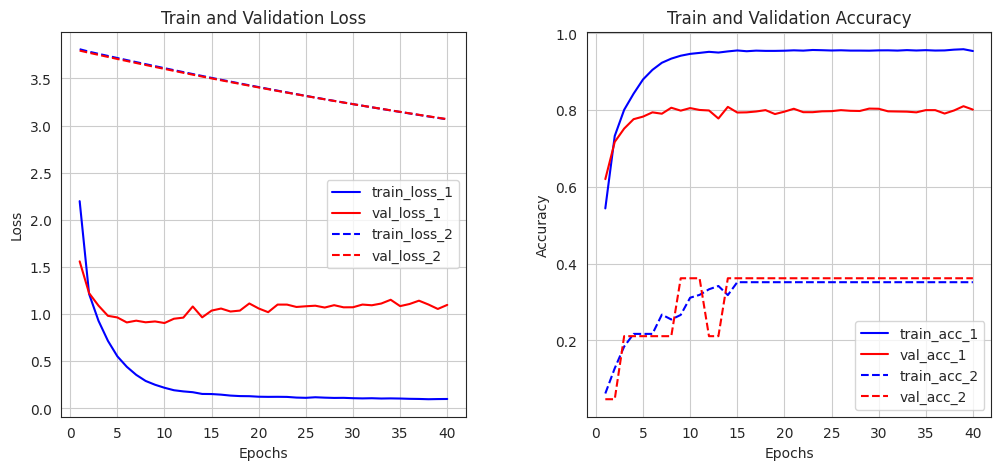

In [ ]:
# 기본 모델 vs zero 초기화 모델
# -> Zeros 초기화는 symmetry 문제로 인해 학습이 거의 되지 않음
diff_history(history, zero_history)

In [ ]:
# 모델 학습: RandomNormal 초기화 방식
# RandomNormal: 가중치를 평균 0, 표준편차 0.05의 정규분포에서 무작위로 초기화
#  -> 비교적 단순한 초기화 방식이지만, 레이어가 깊거나 ReLU 계열 활성화 함수에서는 기울기 소실/폭주 문제가 발생할 수 있음
normal_history = build_model(initializers.RandomNormal())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.3805 - loss: 3.0228 - val_accuracy: 0.6028 - val_loss: 1.7127
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6368 - loss: 1.5462 - val_accuracy: 0.6763 - val_loss: 1.4162
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7211 - loss: 1.2084 - val_accuracy: 0.6870 - val_loss: 1.3141
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7642 - loss: 1.0208 - val_accuracy: 0.7364 - val_loss: 1.1330
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8094 - loss: 0.8189 - val_accuracy: 0.7413 - val_loss: 1.0953
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8386 - loss: 0.7008 - val_accuracy: 0.7649 - val_loss: 1.0192
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8759 - loss: 0.5649 - val_accuracy: 0.7689 - val_loss: 1.0136
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8972 - loss: 0.4552 - val_accuracy: 0.7663 - v

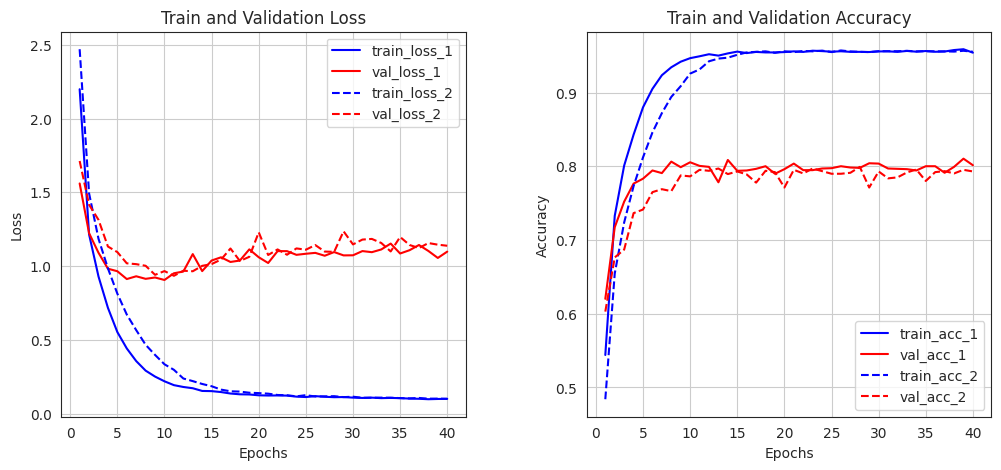

In [ ]:
# 기본 모델 vs RandomNormal 초기화 모델
#  -> loss: RandomNormal은 분산이 적절하지 않으면 초기 학습이 느려질 수 있음
#  -> acc: 초기 성능이 낮고 회복 속도도 느릴 수 있음
diff_history(history, normal_history)

In [ ]:
# 모델 학습: GlorotNormal 초기화 방식
# GlorotNormal: 가중치를 평균 0, 분산인 정규분포에서 샘플링
#  -> 층이 깊어질수록 발생하는 gradient vanishing 또는 exploding 문제 방지
#  -> 적용에 적합한 활성화 함수: tanh, sigmoid, ReLU 등 대부분 가능
glorot_history = build_model(initializers.GlorotNormal())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.4334 - loss: 2.9161 - val_accuracy: 0.6670 - val_loss: 1.5286
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7166 - loss: 1.2923 - val_accuracy: 0.7195 - val_loss: 1.2363
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7924 - loss: 0.9745 - val_accuracy: 0.7591 - val_loss: 1.0651
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8351 - loss: 0.7445 - val_accuracy: 0.7760 - val_loss: 0.9843
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8772 - loss: 0.5728 - val_accuracy: 0.7845 - val_loss: 0.9231
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9040 - loss: 0.4512 - val_accuracy: 0.7925 - val_loss: 0.9049
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9229 - loss: 0.3507 - val_accuracy: 0.7925 - val_loss: 0.9310
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9275 - loss: 0.3240 - val_accuracy: 0.7952 - 

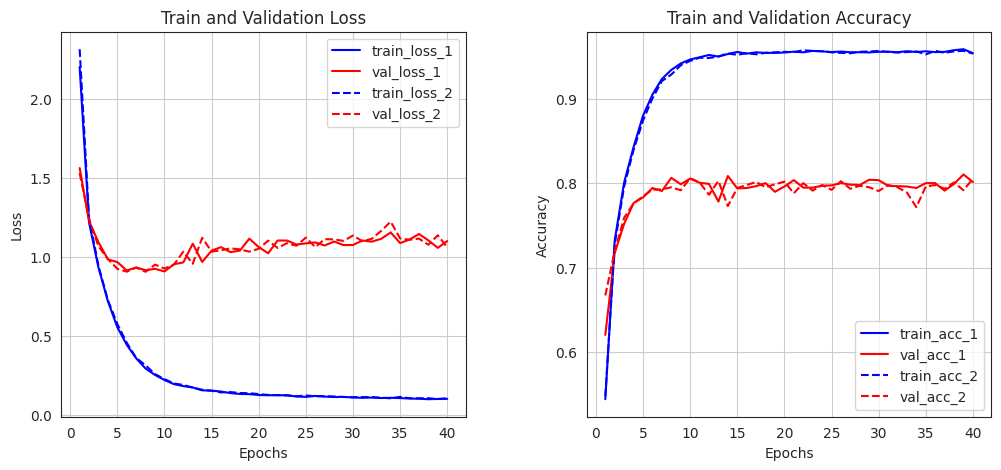

In [ ]:
# 기본 모델 vs GlorotNormal 초기화 모델
#  -> Glorot Normal 초기화는 가중치 분산을 조절해 초기 학습 속도와 안정성에 유리
#  -> Loss와 Accuracy가 더 빠르게 감소/증가하거나, 과적합 없이 더 높은 성능에 도달하면 효과적이라 판단할 수 있음
#  -> 만약 둘의 차이가 크지 않다면, 이 데이터셋에서는 초기화가 큰 영향을 주지 않는다는 의미일 수 있음
diff_history(history, glorot_history)

In [ ]:
# 모델 학습: HeNormal 초기화 방식
# HeNormal: 정규분포에서 표준편차 sqrt(2/fan_in)을 기준으로 샘플링
#  -> ReLU 계열 활성화 함수에 최적화된 가중치 초기화 기법
#  -> 깊은 네트워크에서 Vanishing Gradient 문제를 줄이는 데 효과적
he_history = build_model(initializers.HeNormal())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4506 - loss: 2.7711 - val_accuracy: 0.6843 - val_loss: 1.4130
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7469 - loss: 1.1795 - val_accuracy: 0.7462 - val_loss: 1.1291
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8317 - loss: 0.7949 - val_accuracy: 0.7752 - val_loss: 0.9980
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8731 - loss: 0.5898 - val_accuracy: 0.7818 - val_loss: 0.9537
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9062 - loss: 0.4519 - val_accuracy: 0.7996 - val_loss: 0.9060
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9280 - loss: 0.3514 - val_accuracy: 0.7996 - val_loss: 0.8801
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9386 - loss: 0.2668 - val_accuracy: 0.8001 - val_loss: 0.8792
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9488 - loss: 0.2396 - val_accuracy: 0.7881 - 

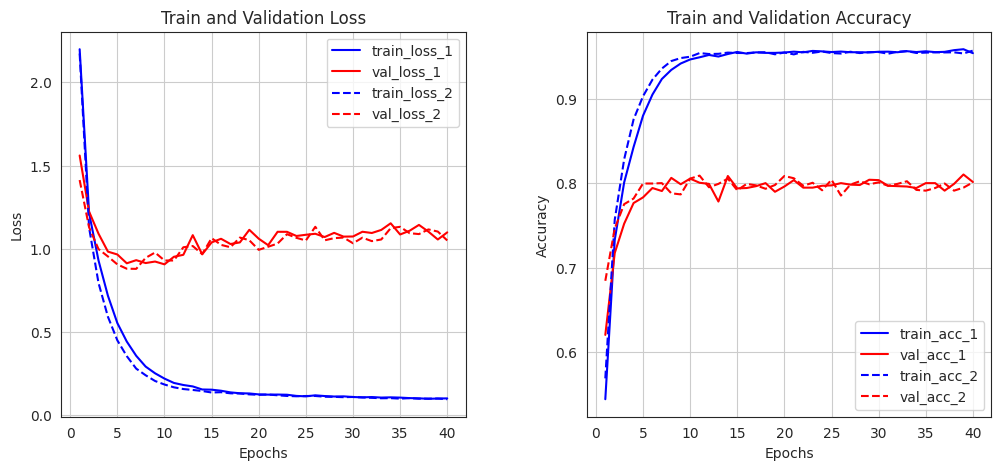

In [ ]:
# 기본 모델 vs HeNormal 초기화 모델
#  -> HeNormal은 ReLU 활성화 함수에 최적화된 초기화 방식이기 때문에
#  -> 일반적인 RandomNormal, Zeros, GlorotNormal에 비해
#  -> 초기 학습 속도나 성능 안정성 면에서 우수한 경우가 많음
diff_history(history, he_history)

<br>

배치 정규화 기법을 통한 다중 분류 모델 구성
- 목적: 배치 정규화(BatchNormalization) 기법을 통해 학습 안정성 향상 및 수렴 속도 개선
- 일반적인 Dense 기반 신경망에 Batch Normalization을 삽입하여 학습 효율을 높인 구조

Batch Normalization
- 은닉층의 입력 분포가 훈련 중 계속 바뀌는 문제(Internal Covariate Shift)를 완화하기 위해 사용
- 각 배치마다 정규화(mean=0, std=1) → 학습 가능한 scale과 shift 적용
- 장점
    - 학습을 안정화시켜 더 높은 학습률을 사용 가능
    - 수렴 속도 향상, 과적합 방지 효과 있음
    - 초기 가중치에 덜 민감해짐

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers

# Sequential 모델 선언
model = models.Sequential()

# 입력층 + 첫 번째 은닉층 (Dense → BatchNorm → ReLU)
model.add(layers.Dense(128, input_shape=(10000,), name='input'))  # 입력 벡터 크기: 10,000차원
model.add(layers.BatchNormalization())                             # 배치 정규화
model.add(layers.Activation('relu'))                               # 활성화 함수 적용

# 두 번째 은닉층 (Dense → BatchNorm → ReLU)
model.add(layers.Dense(128, name='hidden'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# 출력층 (다중 분류: 소프트맥스)
model.add(layers.Dense(46, activation='softmax', name='output'))   # 46개의 클래스

# 모델 컴파일
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,598 (4.97 MB)

 Trainable params: 1,303,086 (4.97 MB)

 Non-trainable params: 512 (2.00 KB)

<br>

Batch Normalization 적용 모델 학습

In [ ]:
batch_norm_history = model.fit(x_train, y_train,
                               epochs=40,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5268 - loss: 2.2368 - val_accuracy: 0.7231 - val_loss: 3.3301
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8746 - loss: 0.6743 - val_accuracy: 0.7329 - val_loss: 3.0713
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9342 - loss: 0.3509 - val_accuracy: 0.6874 - val_loss: 2.7392
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9535 - loss: 0.2192 - val_accuracy: 0.7030 - val_loss: 2.4178
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9601 - loss: 0.1631 - val_accuracy: 0.7084 - val_loss: 2.1096
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9540 - loss: 0.1461 - val_accuracy: 0.6981 - val_loss: 1.8225
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9637 - loss: 0.1142 - val_accuracy: 0.7186 - val_loss: 1.6139
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9582 - loss: 0.1157 - val_accuracy: 0.7476 - 

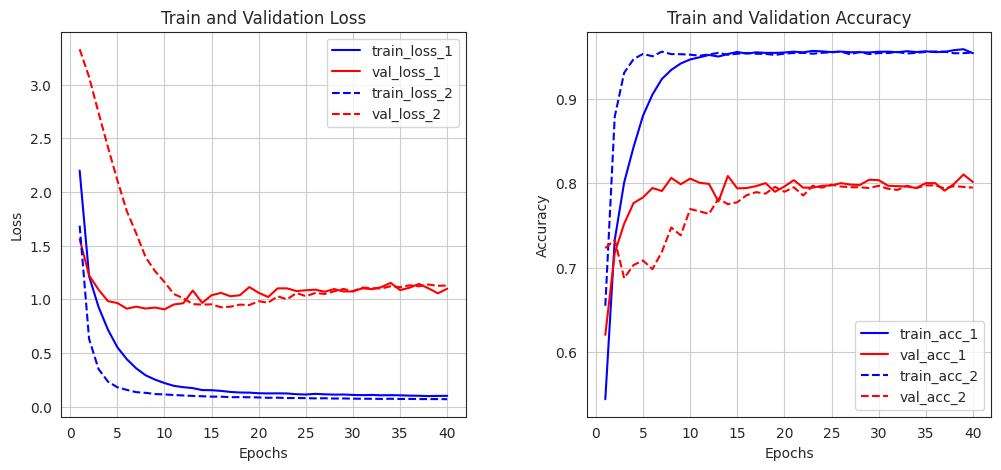

In [ ]:
# 기본 모델 vs Batch Normalization 적용 모델
#  -> loss: 배치 정규화 모델이 더 빠르게 수렴하거나
#           Validation Loss의 진동이 줄어들었다면, 일반화에 도움이 되었다는 의미
#  -> acc: 학습 정확도와 검증 정확도의 간격이 좁아졌다면, 과적합이 줄어든 것으로 해석할 수 있음
diff_history(history, batch_norm_history)

<br>

배치 정규화 위치에 따른 성능 변화 실험
- 배치 정규화(Batch Normalization) 와 활성화 함수(Activation) 의 위치 변경

<br>

- Batch Normalization
    - 각 층의 출력을 정규화(평균 0, 분산 1)하여 학습을 빠르고 안정적으로 만듦
    - 일반적으로 Dense → BN → Activation 순서로 사용하지만, 실험적으로 Activation → BN도 사용
    - 장점: 기울기 폭발/소실 방지, 학습 속도 향상, 과적합 감소

- Activation Function
    - ReLU(Rectified Linear Unit)는 입력이 0보다 작으면 0, 크면 그대로 출력
    - 비선형성을 부여하여 딥러닝의 표현력 향상에 필수

- Softmax
    - 출력층에서 사용
    - 각 클래스에 대한 확률 분포를 반환하고, 다중 클래스 분류 문제에 적합

- Categorical Crossentropy
    - 다중 분류 문제에서 정답(label)이 원-핫 인코딩 형태일 때 사용하는 손실 함수



In [ ]:
"""
원-핫 인코딩된 뉴스 데이터(10,000차원 벡터) 를 입력으로 받아
46개 뉴스 카테고리를 분류하는 딥러닝 모델을 구성
- Batch Normalization과 Activation 레이어의 순서를 바꿔서 모델 성능에 미치는 영향 실험
"""

import tensorflow as tf
from tensorflow.keras import models, layers

# Sequential 모델 생성
model = models.Sequential()

# 입력층: 10,000차원 원-핫 인코딩 벡터 입력 → 128개 유닛 Dense 레이어
model.add(layers.Dense(128, input_shape=(10000,), name='input'))

# 활성화 함수 ReLU (비선형성 추가, 모델 표현력 강화)
model.add(layers.Activation('relu'))

# 배치 정규화 (출력값을 정규화하여 학습 안정성 향상 및 수렴 속도 증가)
model.add(layers.BatchNormalization())

# 은닉층: 128개 유닛 Dense 레이어
model.add(layers.Dense(128, name='hidden'))

# 두 번째 활성화 함수 ReLU
model.add(layers.Activation('relu'))

# 두 번째 배치 정규화
model.add(layers.BatchNormalization())

# 출력층: 46개 클래스에 대한 확률 출력 (softmax는 확률 분포로 변환)
model.add(layers.Dense(46, activation='softmax', name='output'))

# 모델 컴파일
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 128)            │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,303,598 (4.97 MB)

 Trainable params: 1,303,086 (4.97 MB)

 Non-trainable params: 512 (2.00 KB)

<br>

ReLU → BatchNormalization 순서로 구성된 모델 학습

In [ ]:
orderd_bn_history = model.fit(x_train, y_train,
                               epochs=40,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.5239 - loss: 2.3574 - val_accuracy: 0.7199 - val_loss: 3.3071
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9073 - loss: 0.5336 - val_accuracy: 0.7195 - val_loss: 3.1181
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9453 - loss: 0.2937 - val_accuracy: 0.6897 - val_loss: 2.8694
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9564 - loss: 0.2024 - val_accuracy: 0.7039 - val_loss: 2.6078
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9553 - loss: 0.1693 - val_accuracy: 0.7186 - val_loss: 2.3711
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9581 - loss: 0.1428 - val_accuracy: 0.7355 - val_loss: 2.1038
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9542 - loss: 0.1304 - val_accuracy: 0.7275 - val_loss: 1.8842
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9577 - loss: 0.1210 - val_accuracy: 0.7596 - 